In [1]:
# Import necessary libraries

import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import networkx as nx
import matplotlib.pyplot as plt

In [15]:
import warnings
warnings.filterwarnings("ignore")

## Loading the data

In [2]:
# Load the data

df = pd.read_stata('data/PisoFirme_AEJPol-20070024_household.dta')
df.head()

,dpisofirme,idcluster,coord_x,coord_y,idmun,idmza,C_blocksdirtfloor,C_HHdirtfloor,C_child05,C_households,...,S_cesds,S_pss,S_instcement,S_instsanita,S_restsanita,S_constceili,S_restowalls,S_improveany,S_logrent,S_logsell
0,0.0,70000537.0,-103.50367,25.583067,7.0,40,0.3,0.036629,0.555554,819.0,...,14.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,5.298317,9.903487
1,0.0,70000537.0,-103.50367,25.583067,7.0,40,0.3,0.036629,0.555554,819.0,...,17.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,5.298317,9.615806
2,0.0,70000537.0,-103.50367,25.583067,7.0,40,0.3,0.036629,0.555554,819.0,...,16.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,6.214608,10.819778
3,0.0,70000537.0,-103.50367,25.583067,7.0,47,0.3,0.036629,0.555554,819.0,...,20.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,11.385092,11.918390
4,0.0,70000537.0,-103.50367,25.583067,7.0,47,0.3,0.036629,0.555554,819.0,...,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.703783,10.819778


In [3]:
# Define the group durango (the control group of the original paper)
durango = df[df.dpisofirme == 0]

Now we will define the control and treatment group for our experiment. We consider only households which were not proposed Piso Firme (durango). The new treatment group will be households which installed cement floors (S_instcement = 1) by themselve, the new control group will be people who did not install cement floors (S_instcement = 0).

<AxesSubplot:>

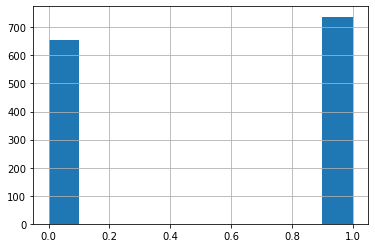

In [4]:
# Plot
durango.S_instcement.hist()

We can see that the two groups are balanced.

## Matching

### Propensity scores computation

In [5]:
# Standardize continuous features

# Define variables for propensity scores (economic variables that could influence installation of cement)

propensity_variables = ['S_incomepc','S_assetspc','S_shpeoplework','S_hrsworkedpc',
                        'S_consumptionpc','S_cashtransfers']

In [6]:
durango = durango.dropna(subset=['S_instcement', 'S_incomepc','S_assetspc','S_shpeoplework','S_hrsworkedpc',
                        'S_consumptionpc','S_cashtransfers'])

durango[propensity_variables]

,S_incomepc,S_assetspc,S_shpeoplework,S_hrsworkedpc,S_consumptionpc,S_cashtransfers
0,1108.333374,35087.679688,0.333333,16.666666,704.000000,0.0
1,1000.000000,53054.988281,0.500000,24.000000,934.250000,0.0
2,1100.000000,52930.226562,0.500000,15.000000,934.140015,0.0
3,660.416687,30632.578125,0.250000,12.000000,324.750000,0.0
4,0.000000,21158.214844,0.000000,0.000000,259.799988,0.0
...,...,...,...,...,...,...
1388,400.000000,20729.542969,0.200000,9.600000,643.099976,0.0
1389,949.714294,15572.803711,0.285714,18.714285,494.519989,0.0
1390,608.000000,20948.089844,0.200000,2.000000,539.599976,64.0
1391,821.777771,35472.132812,0.333333,12.000000,770.433350,0.0


In [7]:
durango.S_instcement.unique()

array([0., 1.])

In [8]:
# Standardize variables used for propensity scores

for v in propensity_variables:
    durango[v] = (durango[v] - durango[v].mean())/durango[v].std()
    
durango[propensity_variables].head()

,S_incomepc,S_assetspc,S_shpeoplework,S_hrsworkedpc,S_consumptionpc,S_cashtransfers
0,0.026686,1.783805,0.572386,0.294665,-0.040731,-0.349656
1,-0.001264,4.238541,1.882376,1.139142,0.147881,-0.349656
2,0.024536,4.221496,1.882376,0.102739,0.147791,-0.349656
3,-0.088875,1.175139,-0.082609,-0.242729,-0.351397,-0.349656
4,-0.259259,-0.119271,-2.047593,-1.624600,-0.404601,-0.349656


In [9]:
# Build the model

mod = smf.logit(formula='S_instcement ~  S_incomepc + S_assetspc + S_shpeoplework + S_hrsworkedpc \
                + S_consumptionpc + S_cashtransfers', data=durango)

res = mod.fit()

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.681915
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:           S_instcement   No. Observations:                 1388
Model:                          Logit   Df Residuals:                     1381
Method:                           MLE   Df Model:                            6
Date:                Thu, 10 Dec 2020   Pseudo R-squ.:                 0.01360
Time:                        20:44:46   Log-Likelihood:                -946.50
converged:                       True   LL-Null:                       -959.54
Covariance Type:            nonrobust   LLR p-value:                 0.0002139
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1296      0.055      2.364      0.018       0.022       0.237
S_incomepc    

In [10]:
# Compute the propensity scores

durango['propensity_score'] = res.predict()

In [43]:
# Define control and treatment groups
treatment = durango[durango.S_instcement == 1]
control = durango[durango.S_instcement == 0]

In [12]:
# Function to compute similarity from two propensity scores
def get_similarity(ps1, ps2):
    return 1-np.abs(ps1 - ps2)

In [13]:
# Matching step using our computed propensity scores

# Create an undirected graph
G = nx.Graph()

# Loop through all the pairs of instances
for treatment_id, treatment_row in treatment.iterrows():
    for control_id, control_row in control.iterrows():
        
        # Calculate the similarity 
        similarity = get_similarity(control_row['propensity_score'],
                                     treatment_row['propensity_score'])
        
        # take epsilon = 0.05 as a threshold for matching
        if similarity > 0.95:
            G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

In [14]:
# put the balanced pairs of papers into one dataframe
match_0 = durango.loc[pd.DataFrame(matching)[0]]
match_1 = durango.loc[pd.DataFrame(matching)[1]]
durango_match = pd.concat([match_0,match_1])

# report the number of pairs
print("The number of matched pairs is {}, and the number of unmatched ones is {}.".format(len(match_0),\
                                                                                     len(treatment)-len(match_0)))

The number of matched pairs is 650, and the number of unmatched ones is 86.


In [74]:
durango_fillna = durango_match.fillna(0,inplace=False)
durango_process = durango_fillna.drop(index = durango_fillna.loc[durango_fillna['idcluster'] == 0].index)
len(durango_process)

1300

In [75]:
durango_match = durango_process

## Regression

### 1. Model specification

In [84]:
# define the dependent outcome variable dataframe
HH_satis = durango_match[['idcluster','S_satisfloor','S_satishouse','S_satislife','S_cesds','S_pss']]
HH_satis

,idcluster,S_satisfloor,S_satishouse,S_satislife,S_cesds,S_pss
1003,71470000.0,0.0,0.0,0.0,15.0,12.0
644,70001446.0,1.0,1.0,1.0,24.0,19.0
805,70001624.0,0.0,1.0,1.0,21.0,15.0
976,70001893.0,1.0,1.0,1.0,14.0,11.0
522,70001408.0,1.0,1.0,1.0,3.0,16.0
...,...,...,...,...,...,...
655,70001446.0,1.0,0.0,0.0,19.0,19.0
469,70001323.0,0.0,0.0,1.0,15.0,13.0
973,70001889.0,1.0,0.0,1.0,29.0,9.0
809,70001624.0,0.0,1.0,1.0,6.0,2.0


In [77]:
# Declare the model 1
def regression_1(dependent):
    mod = smf.ols(formula='dependent ~ C(S_instcement)', data=durango_match)
    res = mod.fit(cov_type='cluster',cov_kwds={'groups':durango_match['idcluster']})
    return res.params[1],res.bse[1],res.pvalues[1]

In [78]:
# Declare the model 2
def regression_2(dependent):
    mod = smf.ols(formula='dependent ~ C(S_instcement) + S_HHpeople + S_headage + \
          S_spouseage + S_headeduc + S_spouseeduc + S_dem1 + S_dem2 + S_dem3 + S_dem4 + \
          S_dem5 + S_dem6 + S_dem7 + S_dem8 + C(S_waterland) + C(S_waterhouse) + C(S_electricity) + \
          C(S_hasanimals) + C(S_animalsinside) + C(S_garbage) + S_washhands', data=durango_match)
    res = mod.fit(cov_type='cluster',cov_kwds={'groups':durango_match['idcluster']})  
    return res.params[1],res.bse[1],res.pvalues[1]

In [79]:
# Declare the model 3
def regression_3(dependent):
    mod = smf.ols(formula='dependent ~ C(S_instcement) + S_HHpeople + S_headage + \
          S_spouseage + S_headeduc + S_spouseeduc + S_dem1 + S_dem2 + S_dem3 + S_dem4 + \
          S_dem5 + S_dem6 + S_dem7 + S_dem8 + C(S_waterland) + C(S_waterhouse) + C(S_electricity) + \
          C(S_hasanimals) + C(S_animalsinside) + C(S_garbage) + S_washhands + S_cashtransfers + \
          C(S_milkprogram) + C(S_foodprogram) + C(S_seguropopular)', data=durango_match)
    res = mod.fit(cov_type='cluster',cov_kwds={'groups':durango_match['idcluster']})  
    return res.params[1],res.bse[1],res.pvalues[1]

### 2. Control mean and deviation

In [57]:
index = ['Satisfaction with floor quality','Satisfaction with house quality','Satisfaction with quality of life',\
         'Depression scale (CES-D scale)','Perceived stress scale (PSS)']
columns = ['control mean','control std','Model 1:coef','Model 1:std','Model 1:sig','Model 1:effect',\
           'Model 2:coef','Model 2:std','Model 2:sig','Model 2:effect','Model 3:coef',\
          'Model 3:std','Model 3:sig','Model 3:effect']
table = pd.DataFrame(index = index, columns = columns)

In [58]:
# divide the data set into treatment and control groups
treated = durango_match.loc[durango_match['S_instcement'] == 1]
controlled = durango_match.loc[durango_match['S_instcement'] == 0]

# calculate and store the mean of the outcome variables for the control group
HH_satis_control = controlled[['S_satisfloor','S_satishouse','S_satislife','S_cesds','S_pss']]
table['control mean'] = np.array(HH_satis_control.mean())

# calculate and store the deviation of the outcome variables for the control group
table['control std'] = np.array(HH_satis_control.std())

In [59]:
def report_result(index, data):
    for i in range(5):
        print('{:40} {:.3f}'.format(index[i],data[i]))

In [60]:
# report the mean of control group
print('{:-^50}'.format('Control mean'))
report_result(index, table['control mean'])

# report the deviation of control group
print(' ')
print('{:-^50}'.format('Control deviation'))
report_result(index, table['control std'])

-------------------Control mean-------------------
Satisfaction with floor quality          0.477
Satisfaction with house quality          0.595
Satisfaction with quality of life        0.577
Depression scale (CES-D scale)           18.631
Perceived stress scale (PSS)             16.294
 
----------------Control deviation-----------------
Satisfaction with floor quality          0.500
Satisfaction with house quality          0.491
Satisfaction with quality of life        0.494
Depression scale (CES-D scale)           9.502
Perceived stress scale (PSS)             7.195


### 3. Estimated coefficient, clustered standard error and p-value

In [85]:
# obtain the coefficient, clustered standard error and p-value of each model
for i in range(5):
    table['Model 1:coef'][i],table['Model 1:std'][i], table['Model 1:sig'][i] = regression_1(HH_satis.iloc[:,i+1])
    table['Model 2:coef'][i],table['Model 2:std'][i], table['Model 2:sig'][i] = regression_2(HH_satis.iloc[:,i+1])
    table['Model 3:coef'][i],table['Model 3:std'][i], table['Model 3:sig'][i] = regression_3(HH_satis.iloc[:,i+1])
    
# report some results to see whether we get it right
# report the estimated coefficients of model 1
print('{:-^50}'.format('The estimated coefficients of model 1'))
report_result(index, table['Model 1:coef'])

# report the clustered standard errors of model 2
print(' ')
print('{:-^50}'.format('The clustered standard errors of model 2'))
report_result(index, table['Model 2:std'])

# report the p-values of model 3
print(' ')
print('{:-^50}'.format('The p-values of model 3'))
report_result(index, table['Model 3:sig'])

------The estimated coefficients of model 1-------
Satisfaction with floor quality          0.075
Satisfaction with house quality          0.022
Satisfaction with quality of life        0.055
Depression scale (CES-D scale)           -0.529
Perceived stress scale (PSS)             0.166
 
-----The clustered standard errors of model 2-----
Satisfaction with floor quality          0.030
Satisfaction with house quality          0.028
Satisfaction with quality of life        0.029
Depression scale (CES-D scale)           0.894
Perceived stress scale (PSS)             0.821
 
-------------The p-values of model 3--------------
Satisfaction with floor quality          0.019
Satisfaction with house quality          0.599
Satisfaction with quality of life        0.186
Depression scale (CES-D scale)           0.900
Perceived stress scale (PSS)             0.684


### 4. Classification of significance level

There are three classifications of significance level in our case.
- p-value<0.01: Significantly different from 0 at 1 percent level.
- p-value<0.05: Significantly different from 0 at 5 percent level.
- p-value<0.10: Significantly different from 0 at 10 percent level.

In [81]:
# define a function which returns the significance level of the results for each model
def significance_level(x):
    p = x
    for i in range(5):
        if p[i] < 0.01:
            p[i] = 0.01
        elif p[i] < 0.05:
             p[i] = 0.05
        elif p[i] < 0.1:
             p[i] = 0.1
    return p

In [86]:
table['Model 1:sig'] = significance_level(table['Model 1:sig'])
table['Model 2:sig'] = significance_level(table['Model 2:sig'])
table['Model 3:sig'] = significance_level(table['Model 3:sig'])

In [87]:
# report the siginificance level of model 1
print('{:-^50}'.format('The significance level of model 1'))
report_result(index, table['Model 1:sig'])

--------The significance level of model 1---------
Satisfaction with floor quality          0.010
Satisfaction with house quality          0.450
Satisfaction with quality of life        0.050
Depression scale (CES-D scale)           0.578
Perceived stress scale (PSS)             0.841


### 5. The average program effect

In [88]:
# calculate the average program effect: 100*coefficient/control mean
for i in range(5):
    table['Model 1:effect'][i] = 100 * table['Model 1:coef'][i]/table['control mean'][i]
    table['Model 2:effect'][i] = 100 * table['Model 2:coef'][i]/table['control mean'][i]
    table['Model 3:effect'][i] = 100 * table['Model 3:coef'][i]/table['control mean'][i]

# report the program effect of model 3
print('{:-^50}'.format('The average program effect of model 1'))
report_result(index, table['Model 1:effect'])

------The average program effect of model 1-------
Satisfaction with floor quality          15.806
Satisfaction with house quality          3.618
Satisfaction with quality of life        9.600
Depression scale (CES-D scale)           -2.841
Perceived stress scale (PSS)             1.020


In [89]:
table

,control mean,control std,Model 1:coef,Model 1:std,Model 1:sig,Model 1:effect,Model 2:coef,Model 2:std,Model 2:sig,Model 2:effect,Model 3:coef,Model 3:std,Model 3:sig,Model 3:effect
Satisfaction with floor quality,0.476923,0.499852,0.0753846,0.0282191,0.01,15.8065,0.0703101,0.0295649,0.05,14.7424,0.0679274,0.029031,0.05,14.2428
Satisfaction with house quality,0.595385,0.491195,0.0215385,0.0284808,0.449503,3.61757,0.0175852,0.0279372,0.529051,2.95359,0.0146324,0.0278057,0.598723,2.45764
Satisfaction with quality of life,0.576923,0.494428,0.0553846,0.0279172,0.05,9.6,0.0384626,0.0293955,0.190721,6.66684,0.0376022,0.0284262,0.185901,6.51772
Depression scale (CES-D scale),18.631172,9.502204,-0.529231,0.952038,0.578284,-2.84057,-0.164639,0.893908,0.853873,-0.883674,-0.113436,0.899615,0.899658,-0.608848
Perceived stress scale (PSS),16.294117,7.194972,0.166154,0.830499,0.84143,1.01972,0.339565,0.820991,0.679165,2.08397,0.328441,0.80817,0.684448,2.0157


## Part 2
